In [1]:
import sympy as sp
from functools import reduce
sp.init_printing()

In [2]:
class Behaviour:

    def __init__(self, name):

        # name for subscripting
        self.name = name

        # meta data
        self._R = sp.Symbol('R_{}'.format(self.name))
        self._S = sp.Symbol('S_{}'.format(self.name))
        self._F = sp.Symbol('F_{}'.format(self.name))

    def R(self):
        return self._R

    def S(self):
        return self._S

    def F(self):
        return self._F

    def I(self):
        if not hasattr(self, 'parent'):
            return sp.Symbol('I_{root}')
        elif not hasattr(self, 'left_sibling'):
            return self.parent.I()
        elif isinstance(self.parent, Sequence):
            return self.left_sibling.I() & self.left_sibling.S()
        elif isinstance(self.parent, Fallback):
            return self.left_sibling.I() & self.left_sibling.F()

    def Omega(self):

        # ancestors
        ancestors = [self]
        while hasattr(ancestors[-1], 'parent'):
            ancestors.append(ancestors[-1].parent)
            
        # right siblings of ancestors with sequence parent
        right_uncles_seq = list()
        for ancestor in ancestors:
            if hasattr(ancestor, 'parent') and isinstance(ancestor.parent, Sequence):
                if hasattr(ancestor, 'right_sibling'):
                    right_uncles_seq.append(ancestor.right_sibling)

        # right siblings of ancestors with fallback parent
        right_uncles_fallback = list()
        for ancestor in ancestors:
            if hasattr(ancestor, 'parent') and isinstance(ancestor.parent, Fallback):
                if hasattr(ancestor, 'right_sibling'):
                    right_uncles_fallback.append(ancestor.right_sibling)
        
        # operating region
        if len(right_uncles_seq) == 0 and len(right_uncles_fallback) == 0:
            return self.I() & (self.R() | self.S() | self.F())
        elif len(right_uncles_seq) == 0 and len(right_uncles_fallback) > 0:
            return self.I() & (self.R() | self.S())
        elif len(right_uncles_seq) > 0 and len(right_uncles_fallback) == 0:
            return self.I() & (self.R() | self.F())
        else:
            return self.I() & self.R()

In [3]:
class Composition:

    def __init__(self, name, children):

        # assign parent
        for child in children:
            child.parent = self

        # assign left and right siblings
        self.children = children
        for i in range(len(children[:-1])):
            children[i+1].left_sibling = children[i]
        for i in range(len(children[1:])):
            children[i].right_sibling = children[i+1]

        # assign self
        self.name = name
        self.children = children

In [4]:
class Sequence(Composition, Behaviour):

    def __init__(self, name, children):

        # relations
        super().__init__(name, children)

    def R(self):

        # running region
        cup = list()
        for j, bj in enumerate(self.children):
            cap = [bj.R(), *[bk.S() for bk in self.children[:j]]]
            cap = reduce(lambda x, y: x & y, cap)
            cup.append(cap)
        return reduce(lambda x, y: x | y, cup)

    def S(self):

        # success region
        cap = [bj.S() for bj in self.children]
        return reduce(lambda x, y: x & y, cap)

    def F(self):

        # failure region
        cup = list()
        for j, bj in enumerate(self.children):
            cap = [bj.F(), *[bk.S() for bk in self.children[:j]]]
            cap = reduce(lambda x, y: x & y, cap)
            cup.append(cap)
        return reduce(lambda x, y: x | y, cup)

In [5]:
class Fallback(Composition, Behaviour):

    def __init__(self, name, children):

        # relations
        super().__init__(name, children)

    def R(self):

        # running region
        cup = list()
        for j, bj in enumerate(self.children):
            cap = [bj.R(), *[bk.F() for bk in self.children[:j]]]
            cap = reduce(lambda x, y: x & y, cap)
            cup.append(cap)
        return reduce(lambda x, y: x | y, cup)

    def S(self):

        # success region
        cup = list()
        for j, bj in enumerate(self.children):
            cap = [bj.S(), *[bk.F() for bk in self.children[:j]]]
            cap = reduce(lambda x, y: x & y, cap)
            cup.append(cap)
        return reduce(lambda x, y: x | y, cup)

    def F(self):

        # failure region
        cap = [bj.F() for bj in self.children]
        return reduce(lambda x, y: x & y, cap)

In [6]:
# Tree from paper
TOK0 = Behaviour('TOK')
ROK = Behaviour('ROK')
DD = Behaviour('DD')
seq0 = Sequence('seq0', [TOK0, ROK, DD])

TOK1 = Behaviour('TOK')
RR = Behaviour('RR')
seq1 = Sequence('seq1', [TOK1, RR])

TD = Behaviour('TD')
MB = Behaviour('MB')
fal0 = Fallback('fal0', [TD, seq0, seq1, MB])

In [7]:
DD.Omega().simplify()

In [8]:
RR.Omega().simplify()

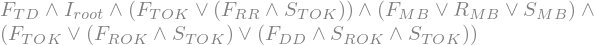

In [9]:
MB.Omega().simplify()

In [10]:
# Assumption: DD and RR always running
# DD._S = False
# DD._F = False
# RR._S = False
# RR._F = False

# Assumption: TD, TOK, and ROK cannot run (conditions)
# TD._R = False
# TOK0._R = False
# TOK1._R = False
# ROK._R = False

In [11]:
DD.Omega().simplify()

In [12]:
RR.Omega().simplify()

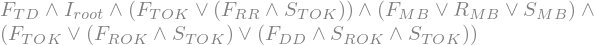

In [13]:
MB.Omega().simplify()

In [18]:
MB.S()

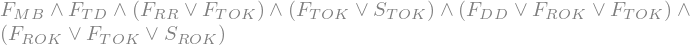

In [21]:
fal0.F().simplify()

In [22]:
fal0.F()

The logical expression for $S$ is
\begin{equation}
S_{TD} \vee \left(F_{TD} \wedge S_{DD} \wedge S_{ROK} \wedge S_{TOK}\right) \vee \left(F_{TD} \wedge S_{MB} \wedge \left(F_{TOK} \vee \left(F_{RR} \wedge S_{TOK}\right)\right) \wedge \left(F_{TOK} \vee \left(F_{ROK} \wedge S_{TOK}\right) \vee \left(F_{DD} \wedge S_{ROK} \wedge S_{TOK}\right)\right)\right) \vee \left(F_{TD} \wedge S_{RR} \wedge S_{TOK} \wedge \left(F_{TOK} \vee \left(F_{ROK} \wedge S_{TOK}\right) \vee \left(F_{DD} \wedge S_{ROK} \wedge S_{TOK}\right)\right)\right)
\end{equation}

Replacing logical and with set intersection, logical or with set union, and logical not with set complement, we get the following set expression for $S$:
\begin{equation}


In [155]:
print(sp.latex(fal0.F()))

F_{MB} \wedge F_{TD} \wedge \left(F_{TOK} \vee \left(F_{RR} \wedge S_{TOK}\right)\right) \wedge \left(F_{TOK} \vee \left(F_{ROK} \wedge S_{TOK}\right) \vee \left(F_{DD} \wedge S_{ROK} \wedge S_{TOK}\right)\right)


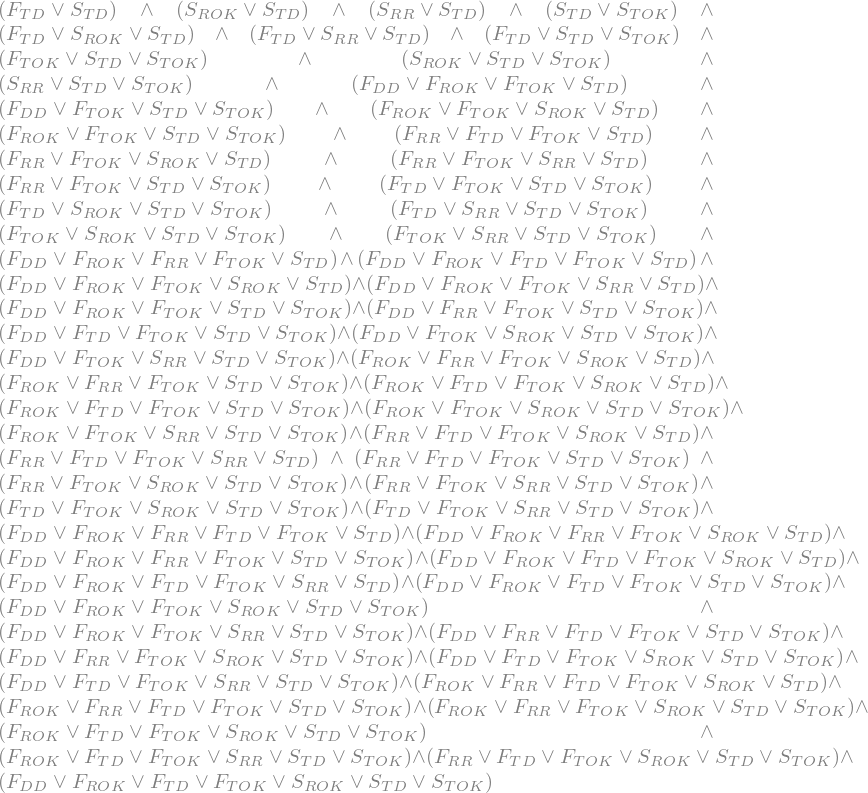

In [99]:
sp.to_cnf(fal0.S()).subs({
    # Order 1
    MB.S() & TD.S(): MB.S(),
    MB.S() | TD.S(): TD.S(),
    DD.S() & TD.S(): DD.S(),
    DD.S() | TD.S(): TD.S(),
    RR.S() & ROK.S(): RR.S(),
    RR.S() | ROK.S(): ROK.S(),
    TD.F() & MB.F(): False,
})